In [1]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "1"

### Importation des librairies et configuration

Dans un premier temps, j’importe l’ensemble des librairies dont j’ai besoin pour le projet :

- **Pandas / NumPy** pour la manipulation des données.
- **Matplotlib / Seaborn** pour les visualisations.
- **Scikit-learn** pour les modèles de machine learning (régression logistique, K-means, PCA, etc.).
- **Statsmodels / SciPy** pour les analyses statistiques (régression linéaire OLS, tests de normalité, colinéarité, homoscédasticité).
- Je limite également le nombre de cœurs utilisés (`LOKY_MAX_CPU_COUNT = 1`) afin d’éviter des problèmes de parallélisation pendant l’exécution.


In [4]:
#Importation des librairies

# Base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pydotplus
from IPython.display import Image

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import (confusion_matrix, accuracy_score)

from scipy.stats import shapiro

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


# Interface utilisateur
import streamlit as st

# Suppression des messages "Warning"
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.cluster._kmeans")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")

In [5]:
nom_fichier = "billets.csv"

# Importer le fichier CSV dans un dataframe

df_billets = pd.read_csv(nom_fichier, delimiter=';')

# Effectuer des opérations sur le dataframe
# Par exemple, afficher les premières lignes du dataframe

df_billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


### Analyse de la qualité des données

Je vérifie ensuite la qualité du jeu de données :

- **Valeurs manquantes** (`isna().mean()`):  
  La seule variable avec des valeurs manquantes significatives est `margin_low` (environ 2,5 %). Les autres variables sont complètes.
- **Doublons** (`duplicated().sum()`):  
  Aucun doublon n’est présent dans le dataset.
- **Nombre de modalités** (`nunique()`):  
  Cela me permet de confirmer que `is_genuine` est bien binaire (vrai/faux) et que les autres variables sont continues.
- **Statistiques descriptives** (`describe()`):  
  Je regarde les moyennes, écarts types, minimums, maximums et quartiles pour avoir un premier aperçu des échelles de mesure et détecter d’éventuelles valeurs aberrantes.

Cette étape permet de confirmer que le jeu de données est globalement propre, à l’exception des valeurs manquantes sur `margin_low` qui devront être traitées.


In [9]:
df_billets.shape


(1500, 7)

In [11]:
df_billets.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [13]:
df_billets.isna().mean()


is_genuine      0.000000
diagonal        0.000000
height_left     0.000000
height_right    0.000000
margin_low      0.024667
margin_up       0.000000
length          0.000000
dtype: float64

In [15]:
df_billets.duplicated().sum()


0

In [17]:
df_billets.nunique()


is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

In [19]:
df_billets.describe()


,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


### Création d’un sous-ensemble sans valeurs manquantes

Pour pouvoir estimer correctement le modèle de régression linéaire, je crée un sous-ensemble du jeu de données en supprimant les lignes contenant des valeurs manquantes (`dropna()`).

Le DataFrame `df_billets_sans_na` contient donc uniquement les observations complètes.  
Je vais m’appuyer sur cet échantillon pour ajuster le modèle destiné à prédire `margin_low`.


In [22]:
faux_vrais_billets = pd.read_csv('billets.csv', sep=";", decimal='.')

In [24]:
faux_vrais_billets.head()


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [26]:
round((faux_vrais_billets['margin_low'].isnull().sum()/faux_vrais_billets.count()*100),2)


is_genuine      2.47
diagonal        2.47
height_left     2.47
height_right    2.47
margin_low      2.53
margin_up       2.47
length          2.47
dtype: float64

In [28]:
faux_vrais_billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [30]:
faux_vrais_billets.dtypes


is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

## Variable Qualitative

<Axes: xlabel='is_genuine'>

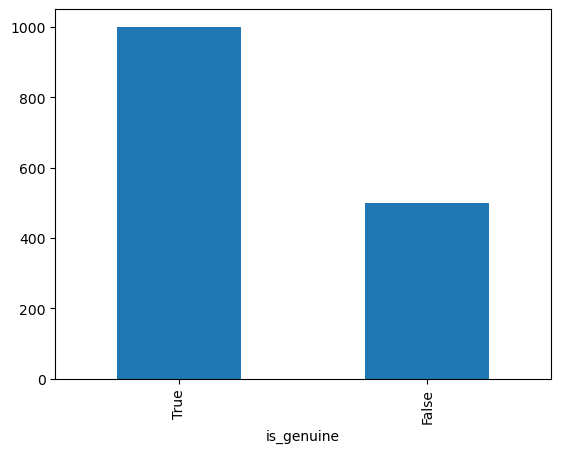

In [33]:
faux_vrais_billets['is_genuine'].value_counts().plot(kind='bar')

## Variable Quantitative

In [36]:
faux_vrais_billets.describe().round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.00,1500.00,1500.00,1463.00,1500.00,1500.00
mean,171.96,104.03,103.92,4.49,3.15,112.68
std,0.31,0.30,0.33,0.66,0.23,0.87
min,171.04,103.14,102.82,2.98,2.27,109.49
25%,171.75,103.82,103.71,4.01,2.99,112.03
50%,171.96,104.04,103.92,4.31,3.14,112.96
75%,172.17,104.23,104.15,4.87,3.31,113.34
max,173.01,104.88,104.95,6.90,3.91,114.44


In [38]:
# On isole les valeurs manquantes pour séparé notre dataframe
margin_vide = faux_vrais_billets[pd.isnull(faux_vrais_billets['margin_low'])]
margin_vide

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36
251,True,171.80,103.26,102.82,NaN,2.95,113.22
284,True,171.92,103.83,103.76,NaN,3.23,113.29
334,True,171.85,103.70,103.96,NaN,3.00,113.36
410,True,172.56,103.72,103.51,NaN,3.12,112.95
413,True,172.30,103.66,103.50,NaN,3.16,112.95


## Visualisation de la répartition des dimensions des billets

In [41]:
def plot_dimensions_distribution(df, columns):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.histplot(data=df, x=col, kde=True, ax=axes[i])
        axes[i].set_title(col)

    plt.tight_layout()
    plt.show()

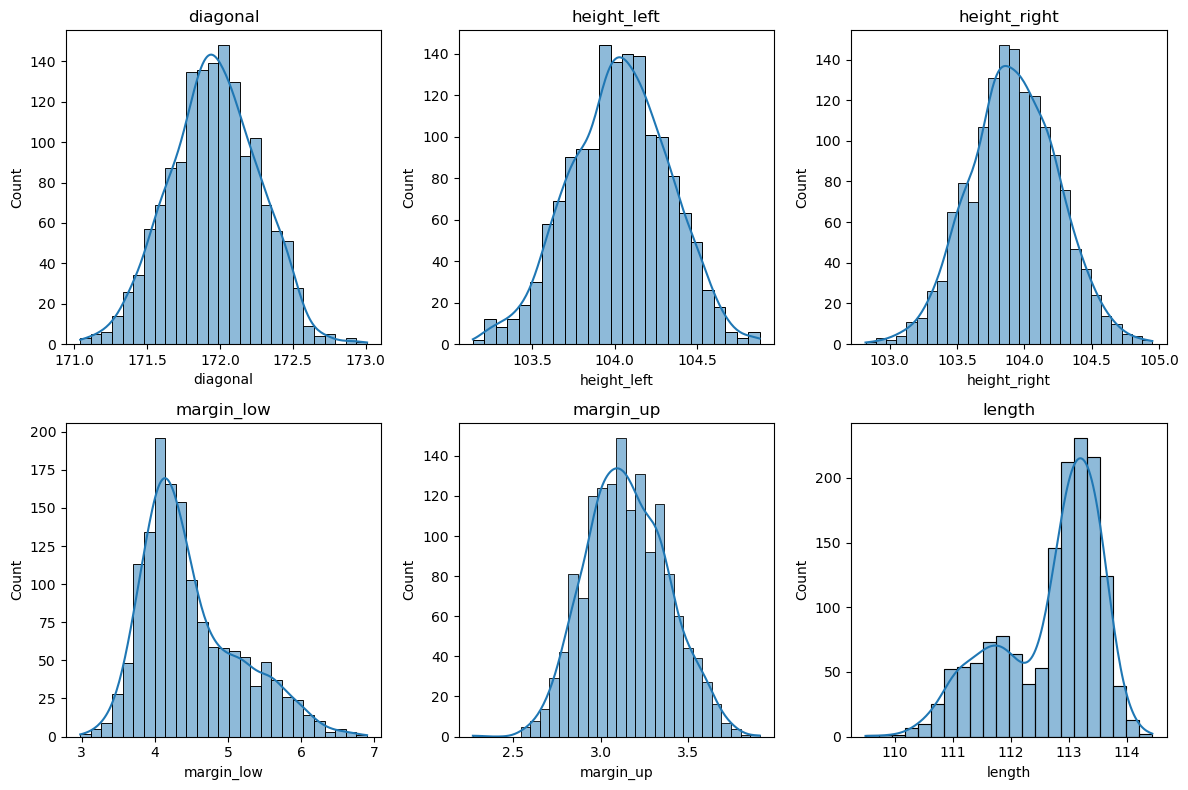

In [43]:
# Visualisation de la répartition des dimensions des billets

columns_to_plot = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
plot_dimensions_distribution(faux_vrais_billets, columns_to_plot)


## Nettoyage des données

In [46]:
# création d'un df dans les valeurs manquantes
df_full = faux_vrais_billets.dropna(inplace=False)
df_full

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


### Régression linéaire pour l’imputation de `margin_low`

L’objectif de cette partie est de construire un **modèle statistique** pour imputer les valeurs manquantes de la variable `margin_low`.

1. **Modèle complet**

Dans un premier temps, j’ajuste un modèle de régression linéaire multiple où `margin_low` est expliquée par toutes les autres variables :

\[
margin\_low \sim diagonal + height\_left + height\_right + length + margin\_up + is\_genuine
\]

Le modèle obtient un **R² d’environ 0,62**, mais plusieurs variables ne sont pas significatives et le condition number est très élevé, ce qui révèle une **forte multicolinéarité** entre les dimensions du billet.

2. **Modèle réduit retenu**

Pour simplifier et stabiliser le modèle, je retiens une spécification réduite :

\[
margin\_low \sim margin\_up + is\_genuine
\]

- Le **R² reste autour de 0,62**, donc on conserve pratiquement la même capacité explicative qu’avec le modèle complet.
- Les deux variables explicatives sont **hautement significatives**.
- Intuitivement :
  - `margin_up` est géométriquement liée à `margin_low`.
  - `is_genuine` permet de capter la différence structurelle entre les billets authentiques et les billets contrefaits.

Ce modèle n’est pas parfait, mais il est **suffisamment bon et parsimonieux** pour l’objectif d’imputation des valeurs manquantes de `margin_low`.


## Régression linéaire multiple ou simple

In [50]:
df_full.corr()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.134720,-0.373624,-0.487177,-0.783032,-0.610412,0.850223
diagonal,0.134720,1.000000,0.018265,-0.019428,-0.111534,-0.059147,0.100758
height_left,-0.373624,0.018265,1.000000,0.235132,0.302643,0.243812,-0.314344
height_right,-0.487177,-0.019428,0.235132,1.000000,0.391085,0.306867,-0.404272
margin_low,-0.783032,-0.111534,0.302643,0.391085,1.000000,0.431606,-0.666753
margin_up,-0.610412,-0.059147,0.243812,0.306867,0.431606,1.000000,-0.521139
length,0.850223,0.100758,-0.314344,-0.404272,-0.666753,-0.521139,1.000000


In [52]:
def corr_heatmap(df):
    plt.figure(figsize=(8, 6))
    sns.heatmap(df.corr(), annot=True, cmap='viridis', fmt=".2f")
    plt.title("Matrice de corrélation")
    plt.show()

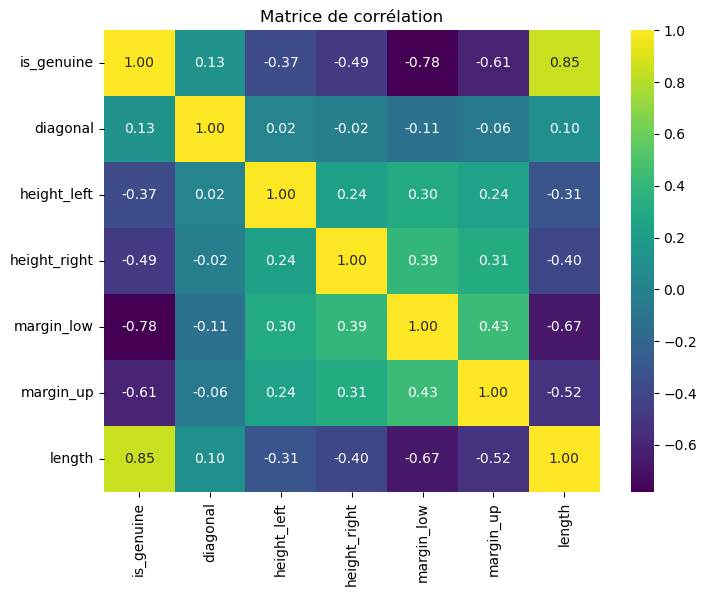

In [54]:
corr_heatmap(df_full)

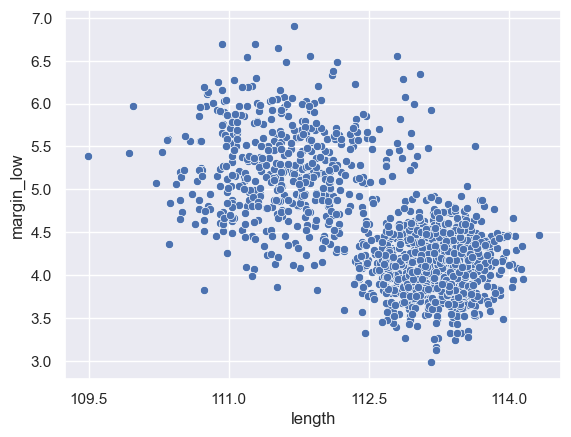

In [56]:
# dans ce nuage de pts on distingue une relation linéaire négative
sns.set()

ax = sns.scatterplot(x="length", y="margin_low", data=df_full)
ax.set(xlabel='length', ylabel='margin_low')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))

Procédure descendante ou backward

On initialise la procédure en intégrant tous les régresseurs, puis on élimine à chaque pas le régresseur associé à la plus petite diminution de la somme des carrés expliqués (la constante est toujours conservée).

## Recherche les variables qui ne sont pas significatives

In [64]:
def backward_selected(X, y, significance_level=0.05):
    """
    Backward elimination : retire les variables non-significatives
    X : DataFrame des variables explicatives
    y : variable cible
    """
    variables = X.columns.tolist()
    removed = True
    
    while removed:
        removed = False
        X_with_const = sm.add_constant(X[variables])
        model = sm.OLS(y, X_with_const).fit()
        
        p_values = model.pvalues.iloc[1:]  # on enlève la constante
        worst_pvalue = p_values.max()
        worst_feature = p_values.idxmax()

        if worst_pvalue > significance_level:
            variables.remove(worst_feature)
            removed = True

    return variables, model

In [68]:
columns_to_plot = ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']

X = df_full[columns_to_plot]
y = df_full['margin_low']

selected_vars, final_model = backward_selected(X, y)

print("Variables retenues :", selected_vars)
print(final_model.summary())

Variables retenues : ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']
                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Wed, 03 Dec 2025   Prob (F-statistic):          2.60e-202
Time:                        09:16:22   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Regression linéaire simple

In [71]:
reg_simp = smf.ols('margin_low ~ length', data=df_full).fit()

In [73]:
print(reg_simp.summary())


                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     1169.
Date:                Wed, 03 Dec 2025   Prob (F-statistic):          8.98e-189
Time:                        09:16:35   Log-Likelihood:                -1045.8
No. Observations:                1463   AIC:                             2096.
Df Residuals:                    1461   BIC:                             2106.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     61.5960      1.670     36.881      0.0

Le R2 est un indice de la qualité de la prédiction de la régression linéaire :

R2 score est le coefficient de détermination, si il est proche de 1, plus la regression linéaire est en adéquation avec les données collectées.

on chois R2 ou R2 ajusté en fonction du nombre de variable que l'on ajoute à notre régression linéaire.

Le coefficient de détermination est actuellement de 0.445

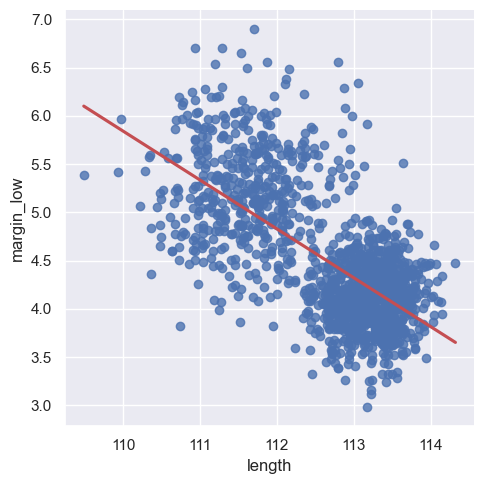

In [76]:
ax = sns.lmplot(x="length", y="margin_low", data=df_full, ci=None, line_kws={'color':'r'})
ax.set(xlabel='length', ylabel='margin_low')
plt.show()

### Analyse des résidus : normalité

Je récupère ensuite les **résidus** du modèle (différence entre les valeurs observées et les valeurs prédites) et je vérifie l’hypothèse de **normalité** :te.
- Cependant, l’**histogramme des résidus** avec la densité superposée montre une distribution globalement symétrique, en forme de cloche.

Conclusion : la normalité des résidus n’est pas parfaite au sens strict des tests, mais la forme globale reste compatible avec une utilisation raisonnable du modèle pour **prédire `margin_low`**.


In [79]:
df_full = df_full.copy()
df_full['residu_s'] = reg_simp.resid


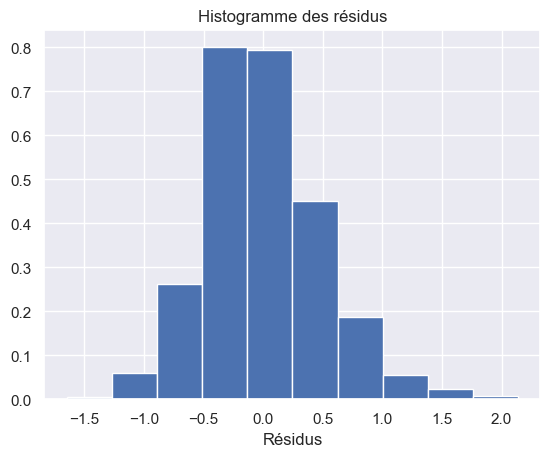

In [81]:
plt.hist(df_full['residu_s'], density=True)
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
plt.show()

In [83]:
# Generer un df (2 regression + constante)
# variables X (j=1,...,q) sont appelées variables indépendantes, ou variables explicatives
X = df_full.loc[:,['length']]
X = sm.add_constant(X)
# La variable Y est appelée variable dépendante, ou variable à expliquer
y = df_full[["margin_low"]]

In [85]:
# Partition aléatoire du jeu de données en 80% pour créer le modèle, 20% pour tester le modèle
# Train set les donneés sont utilisés pour entrainer le modele
# un Test set réserver à l'evaluation 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,random_state=808)

In [87]:
# on fait une première prédiction sur X_test
model = sm.OLS(y_train, X_train)
# fit pour entrainer le modele
resultat = model.fit()

print(resultat.summary())
resultat.params

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     910.4
Date:                Wed, 03 Dec 2025   Prob (F-statistic):          2.41e-148
Time:                        09:16:41   Log-Likelihood:                -840.70
No. Observations:                1170   AIC:                             1685.
Df Residuals:                    1168   BIC:                             1696.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.7668      1.865     32.574      0.0

const     60.766769
length    -0.499553
dtype: float64

In [89]:
resultat.tvalues

const     32.573995
length   -30.172629
dtype: float64

In [91]:
# On va prédire avec OLS
y_pred = resultat.predict(X_test)

In [93]:
performance = pd.DataFrame(y_pred)

In [95]:
performance = performance.merge(y_test, how='inner', left_index=True , right_index=True).rename(columns={0:'PREDICTIONS','margin_low':'ACTUEL VALEUR'})


In [97]:
performance['error'] = (performance['ACTUEL VALEUR'] - performance['PREDICTIONS'])


In [99]:
performance


,PREDICTIONS,ACTUEL VALEUR,error
1309,4.821781,5.50,0.678219
758,4.192344,4.44,0.247656
1098,4.771826,5.08,0.308174
1373,4.871737,5.31,0.438263
1244,5.426241,6.14,0.713759
...,...,...,...
746,4.007509,4.35,0.342491
472,4.047473,4.23,0.182527
61,4.277268,3.99,-0.287268
789,3.897607,4.77,0.872393


In [101]:
# On évalue les métriques ()

print(f"RMSE: {mean_squared_error(y_test, y_pred)}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred)}")
print(f'R2: {r2_score(y_test, y_pred)}')


# Une MAPE de 0,08 semble bien, car plus proche de 0 que de 1.

RMSE: 0.23771936990432854
MAPE: 0.08225951410731557
R2: 0.46872894409299826


## Regression linéaire multiple

In [104]:
#  lancer une régression linéaire multiple sur les variables significatives
reg_multi = smf.ols('margin_low ~ margin_up + length + height_right + height_left + diagonal', data=df_full).fit()

In [106]:
print(reg_multi.summary())


                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Wed, 03 Dec 2025   Prob (F-statistic):          2.60e-202
Time:                        09:16:50   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

In [108]:
# S'il n'y a pas d'autocorrélation, la valeur doit être centré autour de 2
# Generer un df (2 regression + constante)
# variables X (j=1,...,q) sont appelées variables indépendantes, ou variables explicatives
X_multi = df_full.loc[:,['margin_up','length','height_right','height_left','diagonal']]

# Attention ! Statsmodels décide par défaut qu’il n’y a pas de constante, 
# il faut ajouter donc une colonne dans les données pour la constante, on utilise pour cela un outil de statsmodels

X_multi = sm.add_constant(X_multi)
# La variable Y est appelée variable dépendante, ou variable à expliquer
y_multi = df_full[["margin_low"]]


In [110]:
# Partition aléatoire du jeu de données en 80% pour créer le modèle, 20% pour tester le modèle
# Train set les donneés sont utilisés pour entrainer le modele
# un Test set réserver à l'evaluation 
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, train_size=0.8,random_state=808)

In [112]:
# on fait une première prédiction sur X_test
model = sm.OLS(y_train_multi, X_train_multi)
# fit pour entrainer le modele
resultat = model.fit()

print(resultat.summary())
resultat.params

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     207.7
Date:                Wed, 03 Dec 2025   Prob (F-statistic):          2.09e-158
Time:                        09:16:54   Log-Likelihood:                -804.71
No. Observations:                1170   AIC:                             1621.
Df Residuals:                    1164   BIC:                             1652.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           29.8893     10.941      2.732   

const           29.889273
margin_up        0.266499
length          -0.399658
height_right     0.266015
height_left      0.154613
diagonal        -0.145083
dtype: float64

In [114]:
# On va prédire avec OLS
y_pred = resultat.predict(X_test_multi)

performance_mult = pd.DataFrame(y_pred)

performance_mult = performance_mult.merge(y_test_multi, how='inner', left_index=True , right_index=True).rename(columns={0:'PREDICTIONS','margin_low':'ACTUEL VALEUR'})
performance_mult['error'] = (performance_mult['ACTUEL VALEUR'] - performance_mult['PREDICTIONS'])

performance_mult

,PREDICTIONS,ACTUEL VALEUR,error
1309,4.839637,5.50,0.660363
758,4.321169,4.44,0.118831
1098,5.103814,5.08,-0.023814
1373,5.075743,5.31,0.234257
1244,5.270523,6.14,0.869477
...,...,...,...
746,3.861197,4.35,0.488803
472,4.134454,4.23,0.095546
61,4.276096,3.99,-0.286096
789,3.848948,4.77,0.921052


In [116]:
print(f"RMSE : {mean_squared_error(y_test_multi, y_pred)}")
print(f'R2: {r2_score(y_test_multi, y_pred)}')
# Elle quantifie l’erreur réalisée par le modèle : plus elle est élevée, moins le modèle est performant
print(f"MAPE: {mean_absolute_percentage_error(y_test_multi, y_pred)}")
# Une MAPE de 0,08 semble bien, car plus proche de 0 que de 1.


RMSE : 0.22542386521235513
R2: 0.4962077556145127
MAPE: 0.07834383001928405


## Analysez nos résultats

Quelles sont les hypothèses nécessaires pour la régression OLS ?

Les individus (ou observations) sont indépendants. C'est en général vrai dans les situations quotidiennes (la quantité de pluie ne dépend pas de la journée précédente, les bénéfices ne dépendent pas du jour précédent et la taille d'une personne ne dépend pas de la personne mesurée aupavarant...).

La variance est homogène. Le test de Levene est proposé par XLSTAT pour tester l'égalité des variances des erreurs.

Les résidus suivent une distribution normale. XLSTAT propose plusieurs méthodes pour tester la normalité des résidus.

## Vérifier la colinéarité des variables

In [120]:
# ici, les coefficients n'ont pas de problèmes de colinéarité parcequ'ils sont inférieurs à 10
variables = resultat.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.4064160333860858,
 1.6032713501029086,
 1.2503584474765375,
 1.1436301259643633,
 1.0118424163329198]

## Testez la normalité des résidus


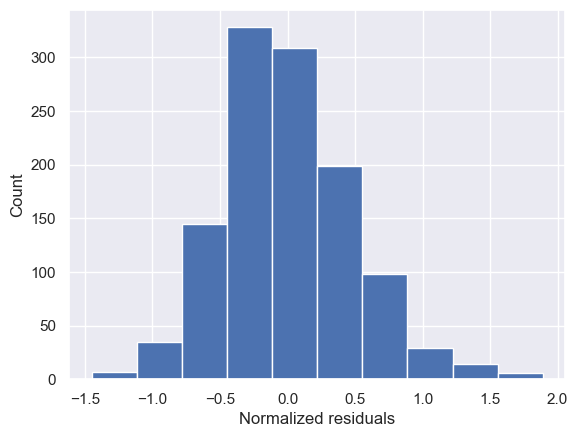

In [123]:
plt.hist(resultat.resid)
plt.ylabel('Count')
plt.xlabel('Normalized residuals')
plt.show()

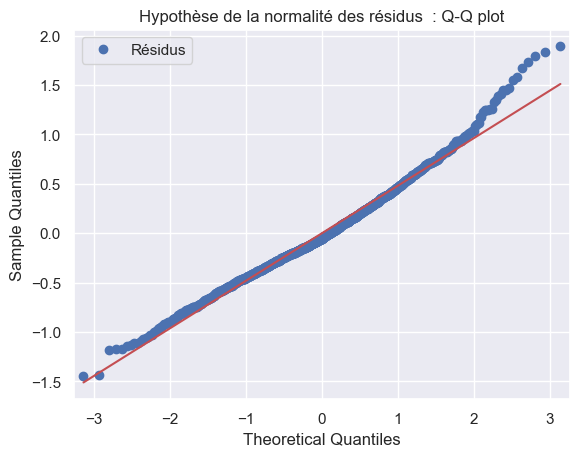

In [125]:
# hypothèse de la normalité des résidus
sm.qqplot(resultat.resid, line='s', label="Résidus")
plt.title("Hypothèse de la normalité des résidus  : Q-Q plot")
plt.legend()
plt.show()

In [127]:
resultat.resid.count()


1170

In [129]:
#perform Shapiro-Wilk test
shapiro(resultat.resid)

ShapiroResult(statistic=0.986635375631838, pvalue=7.182702096199245e-09)

l'hypothèse de normalité est remise en cause (p-value = 0.003 < 0.05) on rejette l'hypothèse 𝐻0, cela signifie que les résidus ne sont pas normalement distribués avec la regression linéaire multiple

## Testez l'homoscédasticité


On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :



In [134]:
variables = resultat.model.exog


In [136]:
_, pval, __, f_pval = sm.stats.diagnostic.het_breuschpagan(resultat.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 2.3716448342289824e-14


La p-valeur ici est pas inférieure à 5%, on rejette l'hypothèse 𝐻0 selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

## On comble les valeurs manquantes avec la prediction multiple


In [140]:
combler_valeur = margin_vide.copy()
# stat mode = ajout d'une constante
combler_valeur = sm.add_constant(combler_valeur)
# on ordonne les colonnes dans cet ordre
combler_valeur = combler_valeur[['const','margin_up','length','height_right','height_left','diagonal']]

In [142]:
# On predit sur les données de combler_valeur
margin_low_predict = resultat.predict(combler_valeur)

margin_low_predict.name = 'margin_low'
combler_valeur = combler_valeur.merge(right=margin_low_predict, how="inner", left_index=True, right_index=True)
combler_valeur

,const,margin_up,length,height_right,height_left,diagonal,margin_low
72,1.0,3.25,112.79,103.45,103.89,171.94,4.314470
99,1.0,3.14,113.08,104.18,104.07,171.93,4.392727
151,1.0,3.02,112.93,104.38,103.80,172.07,4.411841
197,1.0,3.62,113.27,103.80,103.66,171.45,4.349874
241,1.0,3.02,112.36,104.06,104.14,171.83,4.641910
251,1.0,2.95,113.22,102.82,103.26,171.80,3.817983
284,1.0,3.23,113.29,103.76,103.83,171.92,4.185401
334,1.0,3.00,113.36,103.96,103.70,171.85,4.139389
410,1.0,3.12,112.95,103.51,103.72,172.56,4.115605
413,1.0,3.16,112.95,103.50,103.66,172.30,4.152050


In [144]:
margin_vide = margin_vide.merge(right=margin_low_predict, how="inner", left_index=True, right_index=True)

margin_vide.drop(columns='margin_low_x',inplace=True)
margin_vide.rename(columns={'margin_low_y':'margin_low'},inplace=True)

data = pd.concat([df_full, margin_vide])
# on supprime la colonne residu
data = data.drop(columns='residu_s')
# new data pour l'apprentissage des algorithmes de machine learning
data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.520000,2.89,112.83
1,True,171.46,103.36,103.66,3.770000,2.99,113.09
2,True,172.69,104.48,103.50,4.400000,2.94,113.16
3,True,171.36,103.91,103.94,3.620000,3.01,113.51
4,True,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...,...
1303,False,172.17,104.49,103.76,5.002514,2.93,111.21
1315,False,172.08,104.15,104.17,4.765693,3.40,112.29
1347,False,171.72,104.46,104.12,5.699839,3.61,110.31
1435,False,172.66,104.33,104.41,5.143578,3.56,111.47


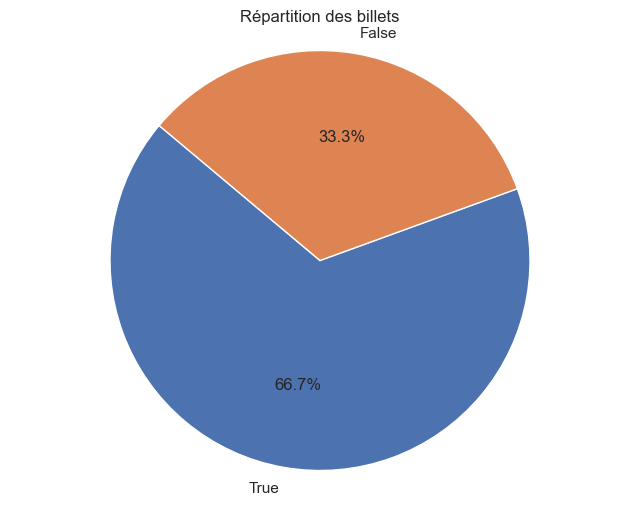

In [146]:
values = data['is_genuine'].value_counts()
labels=['True', 'False']
# Créer un pie chart
plt.figure(figsize=(8, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Assurer que le pie chart est un cercle
plt.title('Répartition des billets')
plt.show()

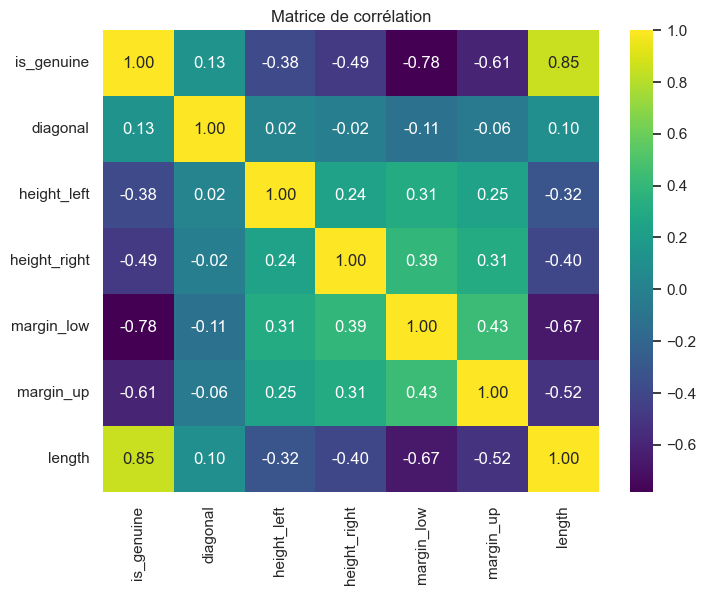

In [148]:
corr_heatmap(data)


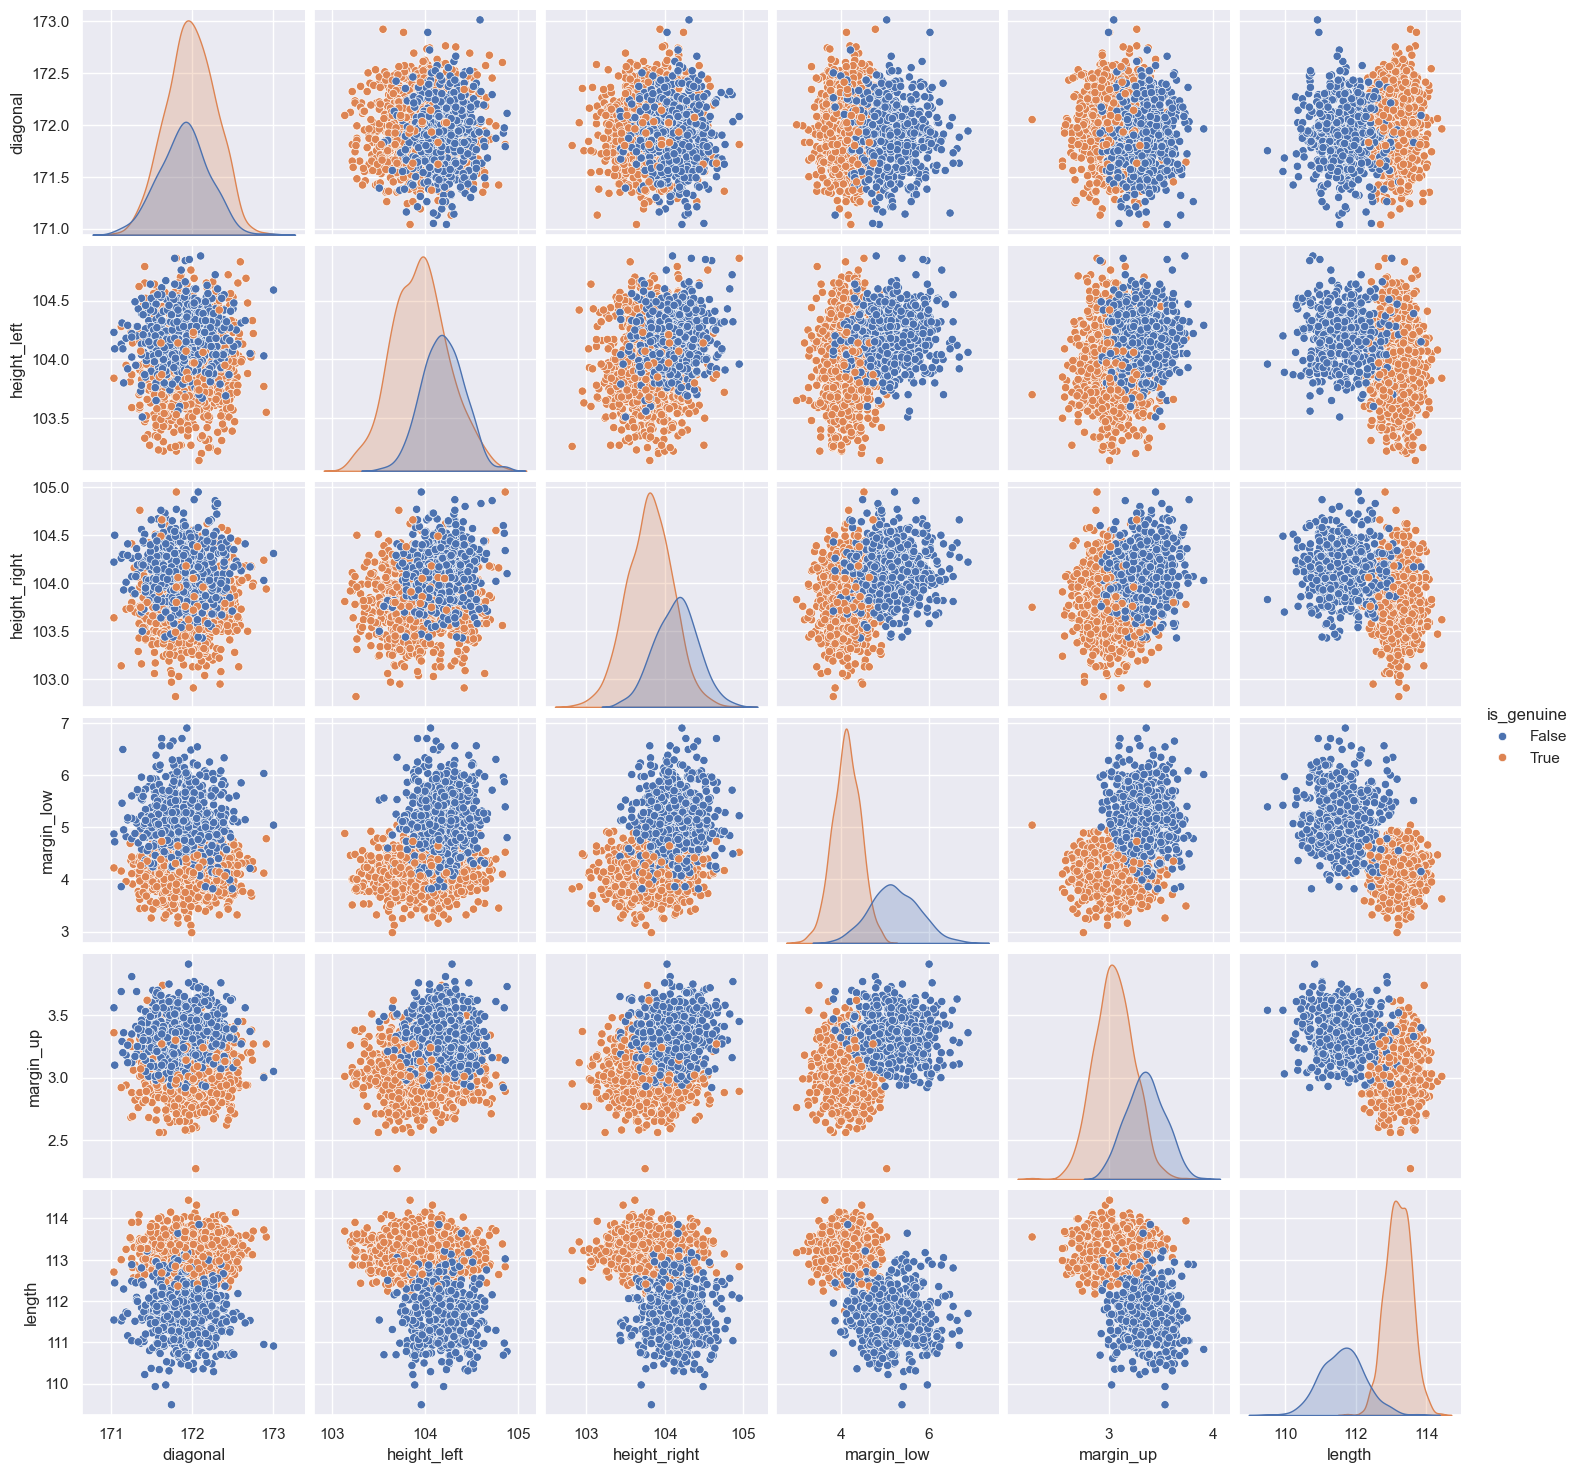

In [150]:
# Créez un pairplot en utilisant Seaborn
sns.pairplot(data=data, hue='is_genuine')

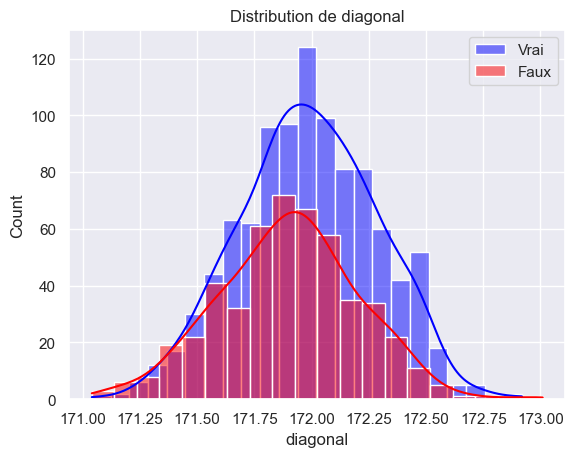

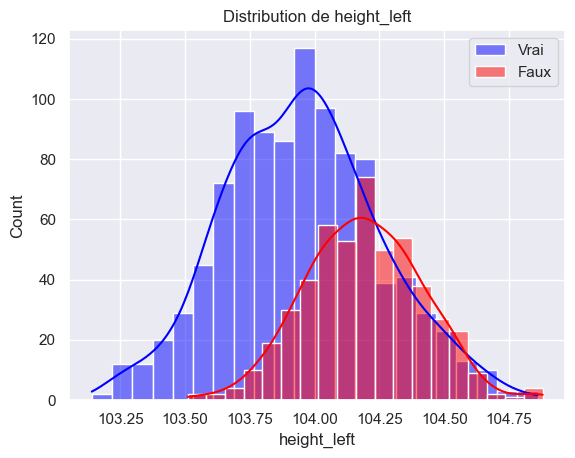

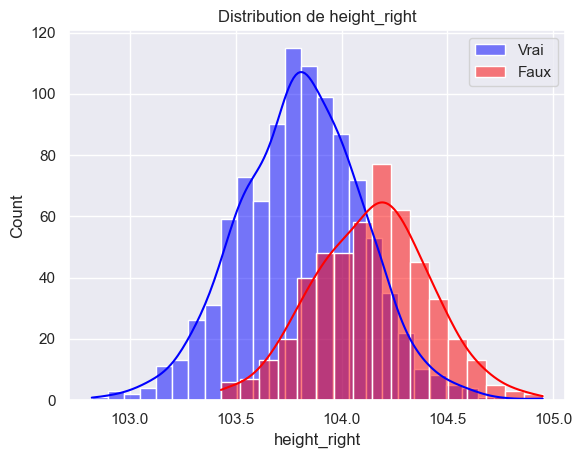

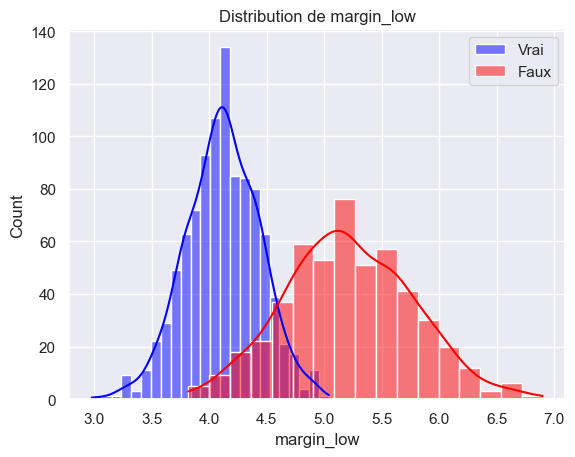

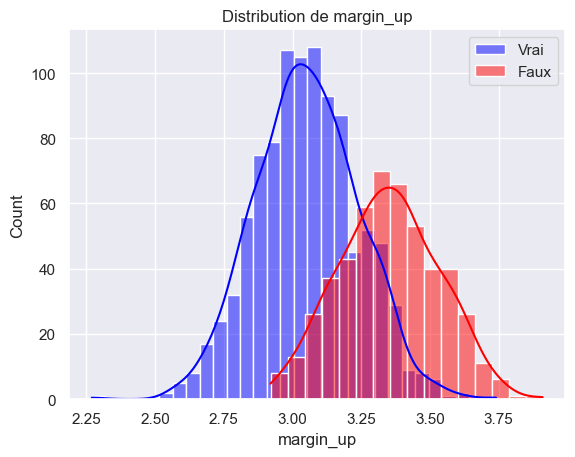

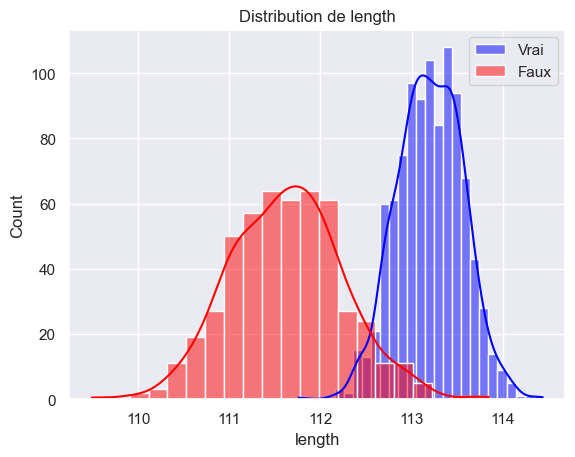

In [152]:
for col in data.columns[1:]:
    plt.figure()
    
    sns.histplot(
        data=data[data['is_genuine']==True],
        x=col,
        kde=True,
        color='blue',
        label='Vrai'
    )

    sns.histplot(
        data=data[data['is_genuine']==False],
        x=col,
        kde=True,
        color='red',
        label='Faux'
    )
    
    plt.legend()
    plt.title(f"Distribution de {col}")
    plt.show()


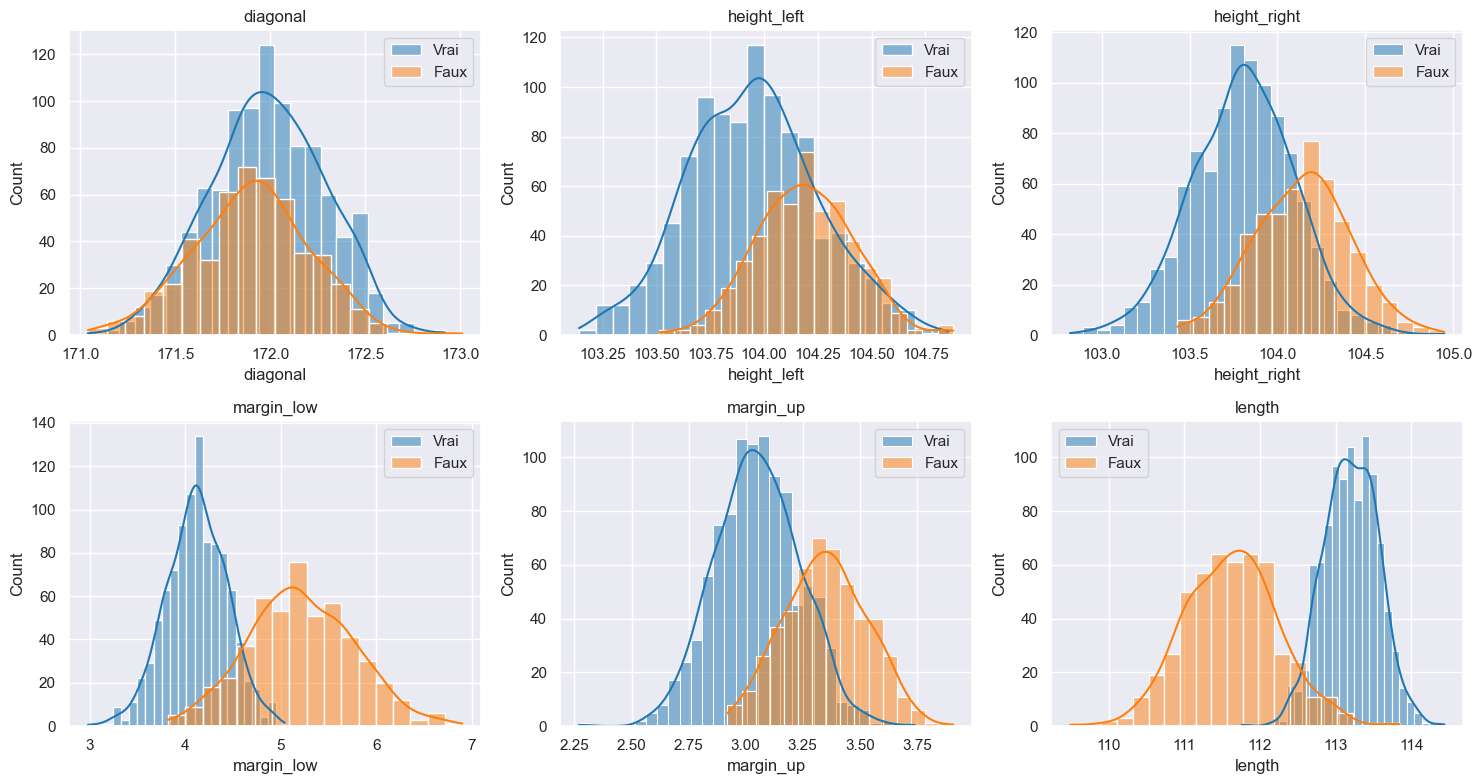

In [154]:
cols = ['diagonal', 'height_left', 'height_right',
        'margin_low', 'margin_up', 'length']

n_cols = 3                     
n_rows = int(np.ceil(len(cols) / n_cols))   

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))
axes = axes.ravel()   

for i, col in enumerate(cols):
    ax = axes[i]
    
  
    sns.histplot(
        data=data[data['is_genuine'] == True],
        x=col,
        kde=True,
        color='tab:blue',
        label='Vrai',
        ax=ax
    )
    
  
    sns.histplot(
        data=data[data['is_genuine'] == False],
        x=col,
        kde=True,
        color='tab:orange',
        label='Faux',
        ax=ax
    )
    
    ax.set_title(col)
    ax.legend()


for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

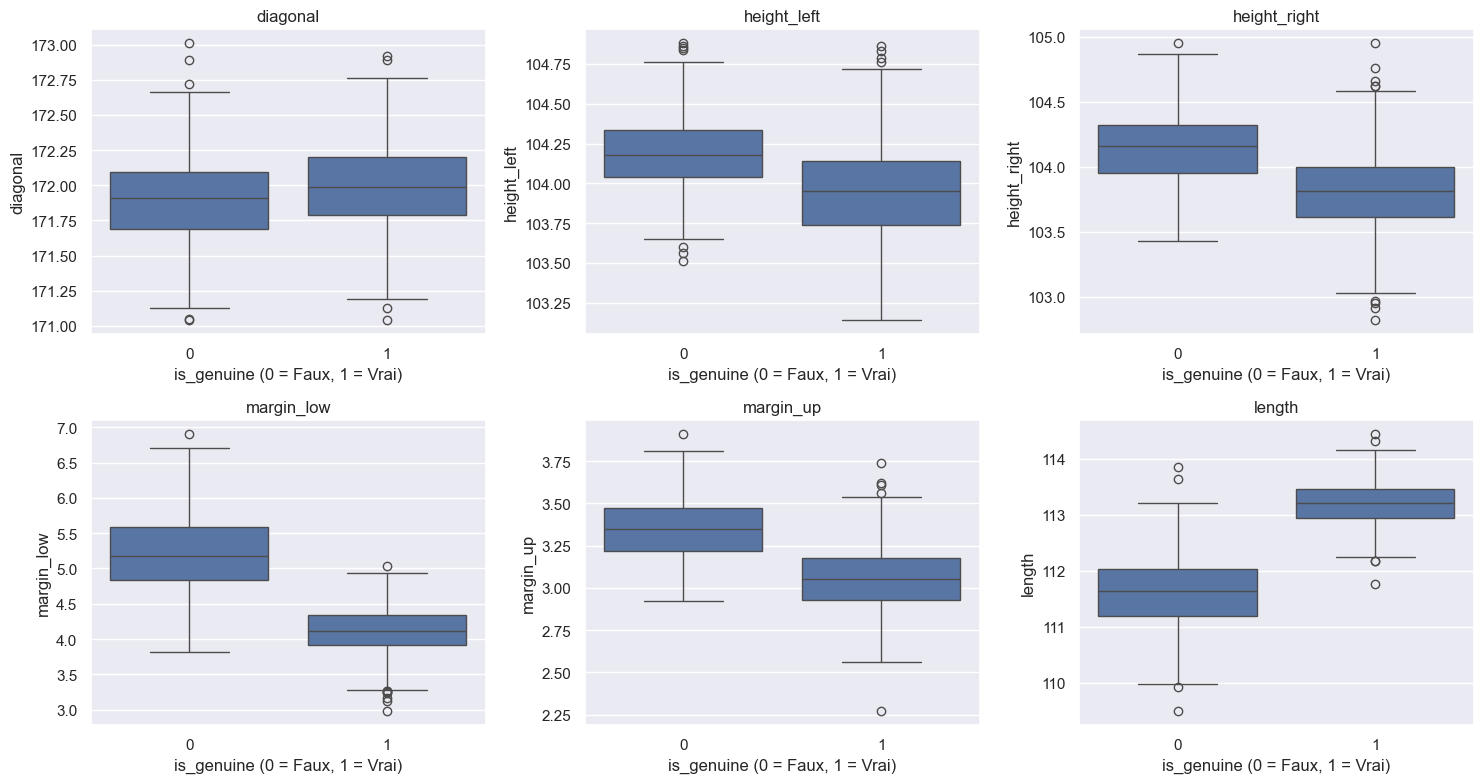

In [155]:
# prepapr boxplot sur is genuine
analyze = data.copy()
analyze['int_is_genuine'] = analyze['is_genuine'].astype(int)

cols = ['diagonal', 'height_left', 'height_right',
        'margin_low', 'margin_up', 'length']

n_cols = 3
n_rows = int(np.ceil(len(cols)/n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))
axes = axes.ravel()

for i, col in enumerate(cols):
    ax = axes[i]
    sns.boxplot(data=analyze, x='int_is_genuine', y=col, ax=ax)
    ax.set_title(col)
    ax.set_xlabel("is_genuine (0 = Faux, 1 = Vrai)")


for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Régression logistique - classification supervisé


In [159]:
# Statsmodels, le package orienté statistique
# on converti la variable explicative en variable explicatative qualitatives ("is_genuine")
df_full['is_genuine'] = df_full['is_genuine'].astype(int)


In [161]:
# on définit x et y
columns_selected = ['margin_low','diagonal','is_genuine','height_left','height_right','margin_up','length']

x = data[columns_selected].drop(['is_genuine'], axis=1)
x = x[['diagonal','height_left','height_right','margin_low', 'margin_up','length']]
# on ne prend que les colonnes qualitatives
y = data['is_genuine']


In [163]:
# on ajoute une colonne pour la constante
x = sm.add_constant(x)

In [165]:
# On définit notre Train Set et notre Test Set
X_train ,X_test, y_train, y_test = train_test_split(x,y, train_size=0.8, random_state=808)


In [167]:
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

X_train (1200, 7)
X_test (300, 7)
y_train (1200,)
y_test (300,)


In [169]:
model_log = sm.Logit(y_train, X_train)
result_model = model_log.fit()

Optimization terminated successfully.
         Current function value: 0.030361
         Iterations 13


In [171]:
result_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1193
Method:                           MLE   Df Model:                            6
Date:                Wed, 03 Dec 2025   Pseudo R-squ.:                  0.9516
Time:                        09:17:58   Log-Likelihood:                -36.433
converged:                       True   LL-Null:                       -752.24
Covariance Type:            nonrobust   LLR p-value:                3.445e-306
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -185.3710    263.122     -0.705      0.481    -701.080     330.339
diagonal         0.0294      1.180      0.025      0.980      -2.284       2.343
height_left     -1.6200      1.196     -1.354      0.176      -3.965       0.724
height_right    -2.1334      1.158     -1.842      0.065      -4.403       0.137
margin_low      -5.6797      1.007     -5.641      0.000      -7.653      -3.706
margin_up      -10.4430      2.319     -4.504      0.000     -14.988      -5.898
length           5.6019      0.870      6.439      0.000       3.897       7.307
================================================================================

Possibly complete quasi-separation: A fraction 0.49 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [173]:
# performing predictions on the test dataset
y_test_pred = result_model.predict(X_test) 
prediction = list(map(round, y_test_pred)) 
  
# comparing original and predicted values of y 
print('Actual values', list(y_test.values)) 
print('Predictions :', prediction) 

Actual values [True, True, True, False, True, True, False, False, True, False, True, True, False, True, False, False, True, True, True, True, True, True, True, True, True, True, True, False, False, True, True, True, False, False, True, True, True, True, False, True, False, True, True, True, True, False, True, True, False, False, True, False, True, True, True, True, True, True, False, True, True, True, True, False, False, False, True, True, True, True, False, True, False, False, True, True, True, True, False, True, False, True, False, True, True, True, False, True, True, True, False, True, True, True, True, False, False, True, True, True, True, True, False, False, False, True, True, False, True, True, False, False, True, True, False, False, True, False, False, True, False, False, False, True, False, True, False, False, False, True, False, False, False, False, True, True, True, True, False, False, True, True, True, True, False, False, False, True, False, False, False, True, True, True, F

In [175]:
y_test_pred

492     0.999969
143     0.999997
105     0.999615
1438    0.000041
808     0.999971
          ...   
93      0.999785
1085    0.000012
1365    0.000114
338     0.999902
212     0.997281
Length: 300, dtype: float64

In [177]:
df_full.iloc[[492,143,105,1438,808],:]


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,residu_s
504,1,171.68,103.95,103.60,3.98,2.93,113.22,-0.229607
145,1,171.65,103.59,103.83,3.97,3.12,113.04,-0.330841
107,1,172.69,103.88,104.06,4.27,3.20,113.22,0.060393
1475,0,172.03,104.48,104.33,5.66,3.01,112.15,0.908056
829,1,172.26,104.14,103.73,4.41,2.96,112.91,0.043267


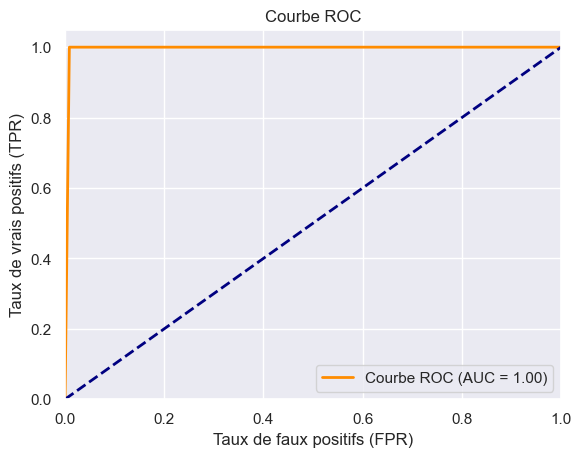

In [179]:
# Calculer le taux de faux positifs (FPR), le taux de vrais positifs (TPR) et les seuils
fpr, tpr, thresholds = roc_curve(y_test, prediction)

# Calculer l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

In [181]:
# confusion matrix 
cm = confusion_matrix(y_test, prediction)  
print ("Confusion Matrix : \n", cm)

Confusion Matrix : 
 [[115   1]
 [  0 184]]


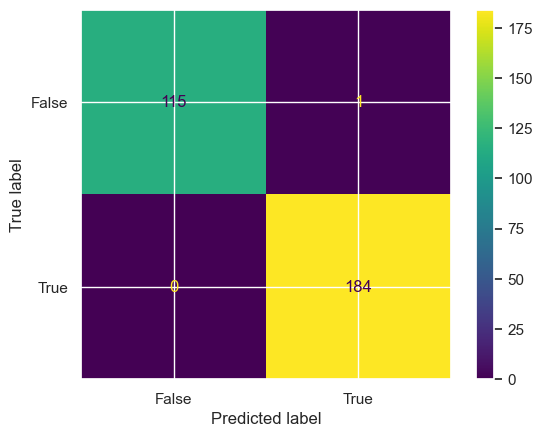

In [183]:
confusion_matrix = metrics.confusion_matrix(y_test, prediction)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show() 


In [185]:
Accuracy_log = metrics.accuracy_score(y_test, prediction)
Sensitivity_recall_log = metrics.recall_score(y_test, prediction)
Specificity_log = metrics.recall_score(y_test, prediction, pos_label=0)
F1_score_log = metrics.f1_score(y_test, prediction)

#metrics
print({"Accuracy":Accuracy_log,"Sensitivity_recall":Sensitivity_recall_log,"Specificity":Specificity_log,"F1_score":F1_score_log}) 

{'Accuracy': 0.9966666666666667, 'Sensitivity_recall': 1.0, 'Specificity': 0.9913793103448276, 'F1_score': 0.997289972899729}


## Kmeans - clustering - classification non supervisé

Clustering : une méthode de classification automatique sans supervision

In [189]:
df_kmeans = data.drop(columns=['is_genuine'])
df_kmeans

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.520000,2.89,112.83
1,171.46,103.36,103.66,3.770000,2.99,113.09
2,172.69,104.48,103.50,4.400000,2.94,113.16
3,171.36,103.91,103.94,3.620000,3.01,113.51
4,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...
1303,172.17,104.49,103.76,5.002514,2.93,111.21
1315,172.08,104.15,104.17,4.765693,3.40,112.29
1347,171.72,104.46,104.12,5.699839,3.61,110.31
1435,172.66,104.33,104.41,5.143578,3.56,111.47


In [191]:
#Normaliser les données si nécessaire
scaler = StandardScaler()

df_scaled = scaler.fit_transform(df_kmeans)

In [193]:
inerties=[]
indice=[]
# on fait une boucle de 1 à 10 pour tester toutes ces possibiliéts
for i in range(1, 11):
    # pour chaque k, on crée un modèle et on l’ajuste
    kmeans=KMeans(n_clusters=i, n_init='auto')
    kmeans.fit(df_scaled)
    # on stocke l’inertie associée
    inerties.append(kmeans.inertia_)
    indice.append(i)
    print("WCSS for K={} --> {}".format(indice, inerties[-1]))

WCSS for K=[1] --> 8999.999999999998
WCSS for K=[1, 2] --> 5805.025992488077
WCSS for K=[1, 2, 3] --> 5092.270915448486
WCSS for K=[1, 2, 3, 4] --> 4677.844946301214
WCSS for K=[1, 2, 3, 4, 5] --> 4359.522213906146
WCSS for K=[1, 2, 3, 4, 5, 6] --> 4251.743011992039
WCSS for K=[1, 2, 3, 4, 5, 6, 7] --> 3937.167026062982
WCSS for K=[1, 2, 3, 4, 5, 6, 7, 8] --> 3790.6190290456066
WCSS for K=[1, 2, 3, 4, 5, 6, 7, 8, 9] --> 3667.3874206478927
WCSS for K=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10] --> 3562.6978236308346


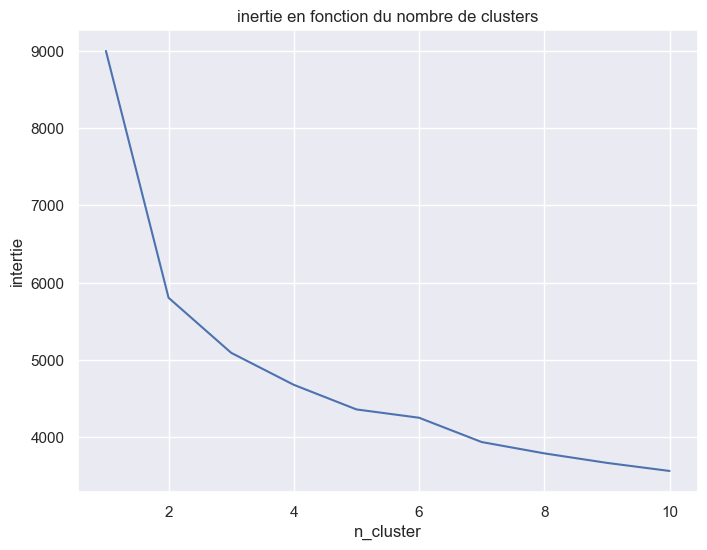

In [194]:
# Graphique de coude
inerties_frame = pd.DataFrame(inerties)
k_frame = pd.Series(indice)

fig, ax = plt.subplots(1,1,figsize=(8,6))

ax.set_title("inertie en fonction du nombre de clusters")
ax.set_ylabel("intertie")
ax.set_xlabel("n_cluster")
ax = plt.plot(indice, inerties_frame.iloc[:,-1])

In [197]:
# Nombre de cluster définie à 2
kmeans = KMeans(n_clusters=2)

# Fit kmeans le dataset
kmeans.fit(df_scaled)

KMeans(n_clusters=2)

In [199]:
# Ajout au df le numéro des clusters
labels = kmeans.labels_
df_kmeans['cluster_kmeans'] = kmeans.labels_

# on voit les moyennes de chaque variables par cluster
clusters_stats = df_kmeans.groupby('cluster_kmeans').mean()
clusters_stats

,diagonal,height_left,height_right,margin_low,margin_up,length
cluster_kmeans,,,,,,
0,171.899153,104.200383,104.152520,5.220584,3.351734,111.630847
1,171.987729,103.945129,103.805588,4.119206,3.052540,113.196066


In [201]:
df_kmeans['is_genuine'] = data['is_genuine']

In [203]:
pd.crosstab(df_kmeans['cluster_kmeans'], df_kmeans['is_genuine'])


is_genuine,False,True
cluster_kmeans,,
0,486,10
1,14,990


In [209]:
df_kmeans['cluster_kmeans'] = df_kmeans['cluster_kmeans'].map({0:1, 1:0})


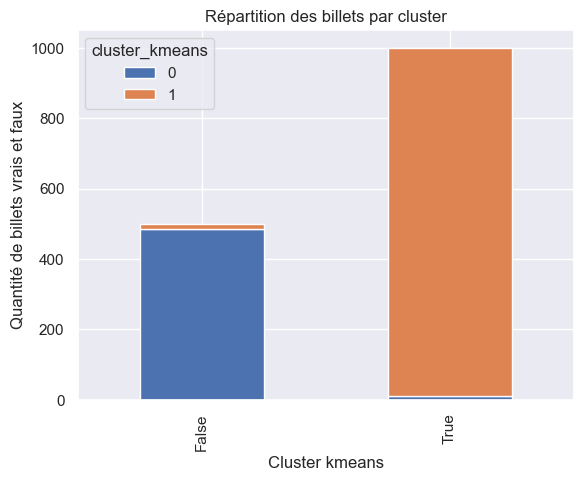

In [211]:
# Créer une table de contingence entre cluster_label et statut_types
contingency_table = pd.crosstab(df_kmeans['is_genuine'], df_kmeans['cluster_kmeans'])

# Tracer le barplot
contingency_table.plot(kind='bar', stacked=True)

# Ajouter des étiquettes et des titres
plt.xlabel('Cluster kmeans')
plt.ylabel('Quantité de billets vrais et faux')
plt.title('Répartition des billets par cluster')

# Afficher le graphique
plt.show()

In [213]:
centroids = kmeans.cluster_centers_
centroids

array([[-0.19432338,  0.57071311,  0.71336493,  1.11818291,  0.86417597,
        -1.20083284],
       [ 0.09600039, -0.28194592, -0.35241933, -0.55240908, -0.42692359,
         0.59324013]])

## PCA

In [216]:
#on utilise l'analyse en composante principal pour visualiser nos clusters - kmeans

n_components = 2
pca = PCA(n_components)
pca.fit(df_scaled)

PCA(n_components=2)

In [218]:
pca.explained_variance_ratio_

array([0.43285668, 0.16957725])

In [220]:
X_proj = pca.transform(df_scaled)
X_proj = pd.DataFrame(X_proj, columns = ["PC1", "PC2"])
X_proj[:10]

,PC1,PC2
0,1.644231,0.749132
1,-2.019618,-2.207788
2,-0.970323,2.619999
3,-1.377200,-1.817760
4,0.148743,-0.565848
5,-0.695762,0.426514
6,0.175794,1.302729
7,-1.151846,-0.383179
8,-0.854855,1.442992
9,-0.597662,1.742869


In [222]:
def display_factorial_planes(X_projected, axes, pca, clusters=None,
                             alpha=1, figsize=(8, 6), marker="o"):
    """
    X_projected : données projetées par la PCA (numpy array ou DataFrame)
    axes        : [i, j] indices des composantes (ex : [0,1])
    pca         : objet PCA déjà entraîné
    clusters    : étiquettes de clusters (optionnel)
    """

    # Assurer qu'on travaille avec un array numpy
    X_proj = np.asarray(X_projected)

    x_axis, y_axis = axes[0], axes[1]

    plt.figure(figsize=figsize)

    # Si on a des clusters → couleur par cluster
    if clusters is not None:
        for lab in np.unique(clusters):
            mask = (clusters == lab)
            plt.scatter(
                X_proj[mask, x_axis],
                X_proj[mask, y_axis],
                alpha=alpha,
                marker=marker,
                label=f"Cluster {lab}"
            )
        plt.legend()
    else:
        plt.scatter(
            X_proj[:, x_axis],
            X_proj[:, y_axis],
            alpha=alpha,
            marker=marker,
        )

    # Titres / labels
    plt.xlabel(f"F{ x_axis+1 } ({ round(100*pca.explained_variance_ratio_[x_axis],1) } %)")
    plt.ylabel(f"F{ y_axis+1 } ({ round(100*pca.explained_variance_ratio_[y_axis],1) } %)")
    plt.title("Projection des individus (sur F1 et F2)")
    plt.axhline(0, color="grey", linewidth=1)
    plt.axvline(0, color="grey", linewidth=1)
    plt.grid(True)
    plt.show()


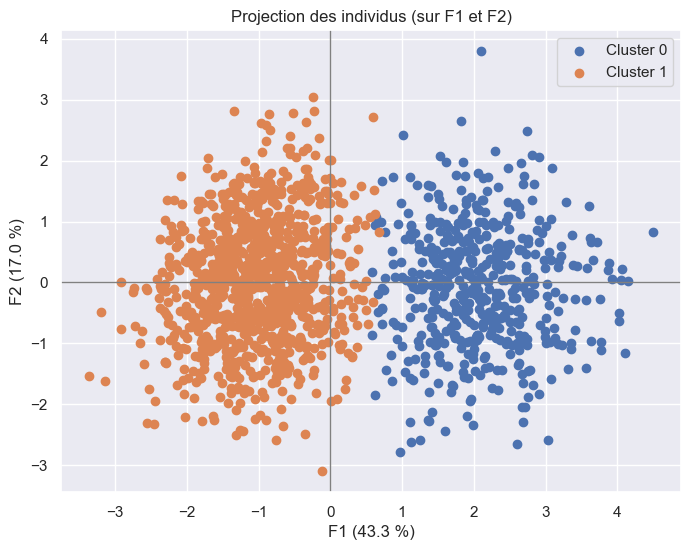

In [224]:
display_factorial_planes(X_proj, [0, 1], pca, clusters=labels, marker="o")


In [226]:
def correlation_circle(pca, axes=(0, 1), feature_names=None, figsize=(8, 8)):
    """
    pca           : objet PCA déjà entraîné (sklearn)
    axes          : (i, j) → indices des composantes à afficher (ex : (0,1) pour F1–F2)
    feature_names : liste des noms de variables (longueur = n_features)
    """

    x_axis, y_axis = axes

    # composantes PCA : shape = (n_components, n_features)
    pcs = pca.components_

    n_features = pcs.shape[1]
    if feature_names is None:
        feature_names = [f"Var{i}" for i in range(n_features)]

    plt.figure(figsize=figsize)

    # Cercle unité
    angle = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(angle), np.sin(angle))
    plt.axhline(0, color="grey", linewidth=1)
    plt.axvline(0, color="grey", linewidth=1)

    # Flèches + labels des variables
    for i in range(n_features):
        x = pcs[x_axis, i]
        y = pcs[y_axis, i]

        plt.arrow(0, 0, x, y,
                  head_width=0.03, head_length=0.03,
                  length_includes_head=True)

        plt.text(1.1 * x, 1.1 * y, feature_names[i])

    # Limites du cercle
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.gca().set_aspect("equal", "box")

    # Titres
    plt.xlabel(f"F{x_axis+1} ({round(100*pca.explained_variance_ratio_[x_axis],1)} %)")
    plt.ylabel(f"F{y_axis+1} ({round(100*pca.explained_variance_ratio_[y_axis],1)} %)")
    plt.title(f"Cercle des corrélations (F{x_axis+1} et F{y_axis+1})")

    plt.grid(False)
    plt.show()

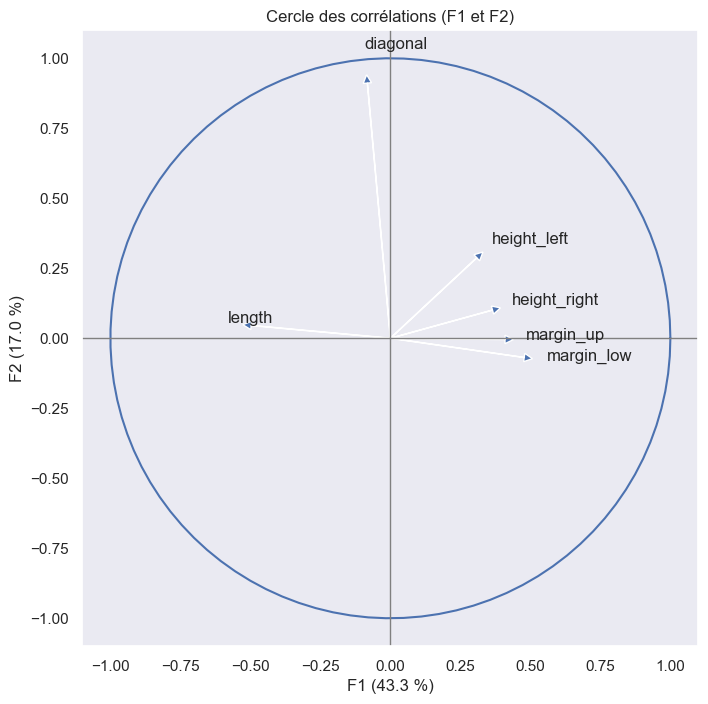

In [228]:
features = ["diagonal", "height_left", "height_right",
            "margin_low", "margin_up", "length"]

# cercle F1–F2
correlation_circle(pca, axes=(0, 1), feature_names=features)

In [230]:
# On utilise bien le scaler déjà entrainé : 
centroids_scaled = scaler.fit_transform(centroids)

# et on utilise l'ACP déjà entrainée : 
centroids_proj = pca.transform(centroids_scaled)

# Création d'un dataframe pour plus de clarté:
centroids_proj = pd.DataFrame(
    centroids_proj,
    columns=["F1", "F2"],
    index=["cluster_0", "cluster_1"]
)

centroids_proj

,F1,F2
cluster_0,2.283157,-0.650868
cluster_1,-2.283157,0.650868


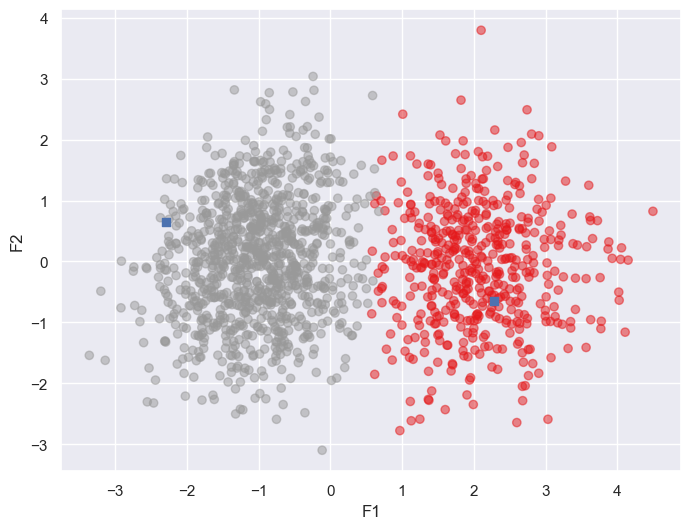

In [232]:
# On définit notre figure et son axe : 
fig, ax = plt.subplots(1,1, figsize=(8,6))

# On affiche nos individus, avec une transparence de 50% (alpha=0.5) : 
ax.scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], c= labels, cmap='Set1', alpha =0.5)

# On affiche nos centroides, avec une couleur noire (c="black") et une frome de carré (marker="c") : 
ax.scatter(centroids_proj.iloc[:, 0], centroids_proj.iloc[:, 1],  marker="s")

# On spécifie les axes x et y :
ax.set_xlabel("F1")
ax.set_ylabel("F2")
plt.show()

In [234]:
centroids_proj

,F1,F2
cluster_0,2.283157,-0.650868
cluster_1,-2.283157,0.650868


## Verification des performances


In [239]:
y_pred = df_kmeans[['cluster_kmeans']]
y_true = df_kmeans['is_genuine'].astype(int)


In [241]:
accuracy = metrics.accuracy_score(y_true, y_pred)
Sensitivity_recall = metrics.recall_score(y_true, y_pred)
Specificity = metrics.recall_score(y_true, y_pred, pos_label=0)
F1_score = metrics.f1_score(y_true, y_pred)

#metrics
print({"Accuracy":accuracy,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score}) 


{'Accuracy': 0.984, 'Sensitivity_recall': 0.99, 'Specificity': 0.972, 'F1_score': 0.9880239520958084}


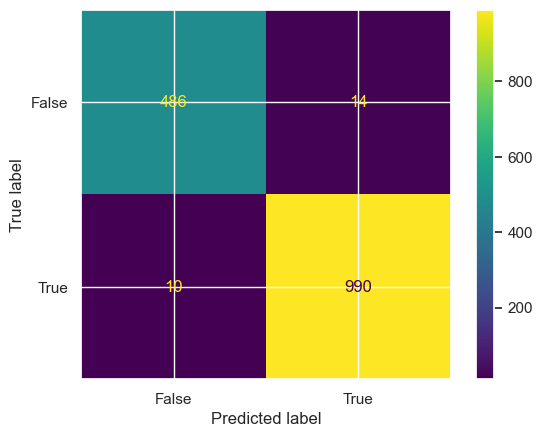

In [243]:
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

Courbe ROC (Receiver Operating Characteristic) : La courbe ROC représente le taux de vrais positifs en fonction du taux de faux positifs pour différents seuils de classification. L'aire sous la courbe ROC (AUC-ROC) est une mesure de la performance globale du modèle.

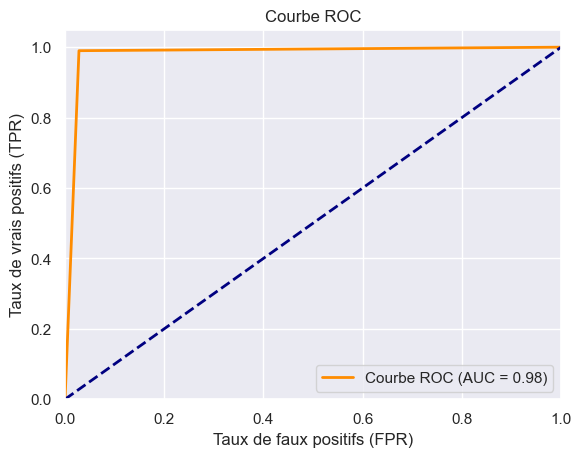

In [246]:
# Calculer le taux de faux positifs (FPR), le taux de vrais positifs (TPR) et les seuils
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Calculer l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

In [248]:
if Accuracy_log > accuracy:
    print("Le modèle de régression logistique est plus performant en termes de généralisation.")
elif Accuracy_log < accuracy:
    print("Le modèle basé sur K-means est plus performant en termes de généralisation.")
else:
    print("Les deux modèles ont la même exactitude en termes de généralisation.")

Le modèle de régression logistique est plus performant en termes de généralisation.


In [250]:
if F1_score_log > F1_score:
    print("Le modèle de régression logistique est plus performant en termes de généralisation.")
elif F1_score_log < F1_score:
    print("Le modèle basé sur K-means est plus performant en termes de généralisation.")
else:
    print("Les deux modèles ont la même exactitude en termes de généralisation.")

Le modèle de régression logistique est plus performant en termes de généralisation.


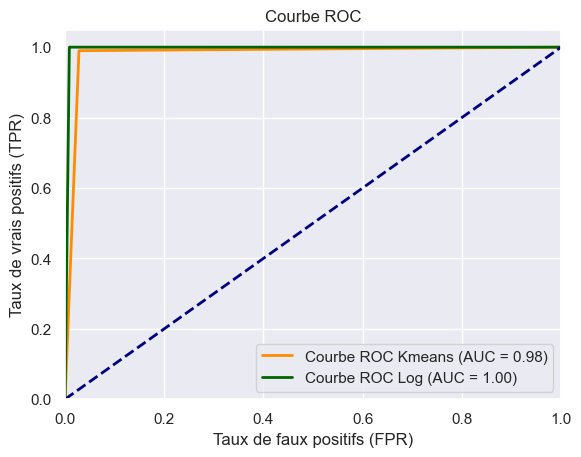

In [252]:
# Calculer le taux de faux positifs (FPR), le taux de vrais positifs (TPR) et les seuils
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
f, t, thresholds = roc_curve(y_test, prediction)
# Calculer l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)
# Calculer l'aire sous la courbe ROC (AUC)
roc_auc_s = auc (f, t)
# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC Kmeans (AUC = %0.2f)' % roc_auc)
plt.plot(f, t, color='darkgreen', lw=2, label='Courbe ROC Log (AUC = %0.2f)' % roc_auc_s)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

## regression logistique sur le fichier billet production

In [274]:
billets_production = pd.read_csv('billets_production.csv', sep=',')

In [276]:
def test_algo_soutenance(data, model):
    # set index l'id
    data = data.set_index('id')
    data_order_columns = data[['diagonal','height_left','height_right','margin_low', 'margin_up','length']]
    # Ajout de la constante
    data_input = sm.add_constant(data_order_columns)
    # Prediction sur le dataframe
    data_predict = model.predict(data_input)
    # Ajout colonne predict avec les values
    data['predict'] = data_predict
    # condition si predict <= 0.5 Faux billet sinon Vrai billet
    data['is_genuine'] = data[['predict']].apply(lambda row: "True" if row['predict'] >= 0.5 else "False",axis=1)
    # retourne le dataframe
    return data

In [278]:
resultat_algo_test = test_algo_soutenance(billets_production,result_model)

In [280]:
resultat_algo_test

,diagonal,height_left,height_right,margin_low,margin_up,length,predict,is_genuine
id,,,,,,,,
A_1,171.76,104.01,103.54,5.21,3.30,111.42,0.000068,False
A_2,171.87,104.17,104.13,6.00,3.31,112.09,0.000006,False
A_3,172.00,104.58,104.29,4.99,3.39,111.57,0.000017,False
A_4,172.49,104.55,104.34,4.44,3.03,113.20,0.993387,True
A_5,171.65,103.63,103.56,3.77,3.16,113.33,0.999988,True
